In [1]:
import pandas as pd
import keras
import numpy as np
import os
from tqdm import tqdm
from time import time
from sklearn.metrics import roc_curve,roc_auc_score,f1_score,accuracy_score,precision_recall_curve
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,KFold
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image,ImageOps
import glob 
import cv2
import pickle
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 1.x
except Exception:
  pass

TensorFlow is already loaded. Please restart the runtime to change versions.


In [2]:
os.chdir("/content/drive/Shared drives/ECS 289G Deep Learning Project/Project/Datasets/")
!ls

 bin_files			        images_pickled
'csv files'			        images_zip_files
 Data_Entry_2017_v2020.gsheet	       'Process NIH Dataset Details.ipynb'
'Filter and Create Sample Sets.ipynb'  'Sample Set Images.ipynb'
 images


In [3]:
with open("bin_files/train_AP.pkl",'rb') as f:
  _,y_train = pickle.load(f)

In [4]:
#load the test files
with open("bin_files/test_AP.pkl",'rb') as f:
	X_test_scale,y_test = pickle.load(f)

X_test_scale.shape

(400, 256, 256, 1)

In [5]:
y_test.shape

(400, 15)

In [6]:
y_test[:10]

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [7]:
y_test_single_labels = np.where(y_test==1)[1]
y_test_single_labels.shape

(400,)

In [8]:
y_test_single_labels[:10]

array([ 4,  0, 14,  2,  0,  3,  2,  0,  3,  1])

In [9]:
from collections import Counter
dict(Counter(y_test_single_labels))

{0: 162, 1: 77, 2: 61, 3: 25, 4: 20, 5: 6, 6: 2, 9: 10, 10: 24, 12: 5, 14: 8}

In [10]:
classes = ['No Finding','Infiltration',
           'Effusion','Atelectasis','Nodule', 'Mass',
           'Pleural_Thickening','Fibrosis','Pneumothorax',
           'Cardiomegaly','Consolidation','Emphysema',
           'Pneumonia','Hernia','Edema']

mapper = dict(zip(range(0,len(classes)),classes))
mapper

{0: 'No Finding',
 1: 'Infiltration',
 2: 'Effusion',
 3: 'Atelectasis',
 4: 'Nodule',
 5: 'Mass',
 6: 'Pleural_Thickening',
 7: 'Fibrosis',
 8: 'Pneumothorax',
 9: 'Cardiomegaly',
 10: 'Consolidation',
 11: 'Emphysema',
 12: 'Pneumonia',
 13: 'Hernia',
 14: 'Edema'}

In [11]:
def get_one_hot_stuff(true_labels,mapper_order):
  true_labels_all = np.zeros((len(true_labels),14))
  for i in range(len(true_labels_all)):
    label = true_labels[i]
    true_labels_all[i,mapper_order[label]] = 1
  
  print(true_labels_all.shape)
  return true_labels_all

In [12]:
# Plot the ROC curves for the output for each label in the test class.
def get_roc_curve(true_labels, predicted_vals):
    auc_roc_vals = []
    for i in range(len(classes)):
      try:
        gt = true_labels[:, i]
        pred = predicted_vals[:, i]
        auc_roc = roc_auc_score(gt, pred)
        auc_roc_vals.append(auc_roc)
        fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
        plt.figure(1, figsize=(10, 10))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_rf, tpr_rf,
                  label=mapper[i] + " (" + str(round(auc_roc, 3)) + ")")
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
      except:
        pass
    
    plt.show()
    return auc_roc_vals

In [13]:
def get_roc_curve_again(labels, predicted_vals, true_label):
    auc_roc_vals = []
    
    for i in range(len(labels)):
        try:
          gt = true_label[:, i]
          pred = predicted_vals[:, i]
          
          auc_roc = roc_auc_score(gt, pred)
          
          auc_roc_vals.append(auc_roc)
          fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
          plt.figure(1, figsize=(10, 10))
          plt.plot([0, 1], [0, 1], 'k--')
          plt.plot(fpr_rf, tpr_rf,
                    label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
          plt.xlabel('False positive rate')
          plt.ylabel('True positive rate')
          plt.title('ROC curve')
          plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

## **Work on the baseline CNN model results**

In [14]:
with open("bin_files/regular_CNN/trainHistoryDict",'rb') as f:
  history_baseline = pickle.load(f)

history_baseline

{'accuracy': [0.484499990940094,
  0.6384999752044678,
  0.6384999752044678,
  0.6384999752044678,
  0.6384999752044678,
  0.6384999752044678,
  0.6384999752044678,
  0.6384999752044678,
  0.6384999752044678,
  0.6384999752044678],
 'loss': [508.53485107421875,
  1.656827449798584,
  1.5518158674240112,
  1.5174397230148315,
  1.5076804161071777,
  1.5123645067214966,
  1.515419840812683,
  1.5047717094421387,
  1.5093941688537598,
  1.5097931623458862],
 'val_accuracy': [0.5879999995231628,
  0.5879999995231628,
  0.5879999995231628,
  0.5879999995231628,
  0.5879999995231628,
  0.5879999995231628,
  0.5879999995231628,
  0.5879999995231628,
  0.5879999995231628,
  0.5879999995231628],
 'val_loss': [2.1143064498901367,
  1.836464285850525,
  2.062025308609009,
  2.162484884262085,
  2.2327146530151367,
  2.1290507316589355,
  2.101653814315796,
  2.1708450317382812,
  2.0282697677612305,
  1.9132680892944336]}

In [15]:
epochs = range(1,11)
train_acc = np.array(history_baseline['accuracy'])*100.00
val_acc = np.array(history_baseline['val_accuracy'])*100.00

train_loss = history_baseline['loss']
val_loss = history_baseline['val_loss']

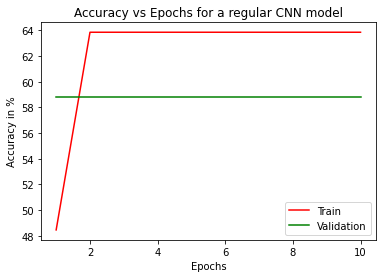

In [16]:
plt.figure()
plt.title("Accuracy vs Epochs for a regular CNN model")
plt.plot(epochs[:],train_acc[:],'red',label = "Train")
plt.plot(epochs,val_acc,'green',label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy in %")
plt.legend()
plt.show()

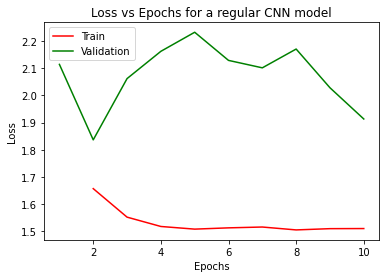

In [17]:
plt.figure()
plt.title("Loss vs Epochs for a regular CNN model")
plt.plot(epochs[1:],train_loss[1:],'red',label = "Train")
plt.plot(epochs,val_loss,'green',label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [18]:
# load YAML and create model
with open('bin_files/regular_CNN/model.yaml', 'r') as yaml_file:
  loaded_model_yaml = yaml_file.read()

loaded_model = keras.models.model_from_yaml(loaded_model_yaml)
# load weights into new model

loaded_model.load_weights("bin_files/regular_CNN/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [19]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 250, 128)     6400      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 119, 119, 128)     802944    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 59, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 128)       802944    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
dense (Dense)                (None, 26, 26, 50)        6

In [20]:
loaded_model.get_weights()

[array([[[[-0.09044291, -0.06816097, -0.02437612, ..., -0.02690412,
           -0.06587826, -0.04970252]],
 
         [[-0.07267347, -0.05244484, -0.03905483, ..., -0.02232995,
           -0.02069872, -0.08831226]],
 
         [[-0.02919043, -0.05790234, -0.08254261, ..., -0.03787492,
           -0.07759085, -0.04385642]],
 
         ...,
 
         [[-0.0930471 , -0.04259926, -0.06771944, ..., -0.02267103,
           -0.07483553, -0.07700671]],
 
         [[-0.04770709, -0.04107742, -0.04780303, ..., -0.02255229,
           -0.05807344, -0.03373852]],
 
         [[ 0.00362143, -0.0690518 , -0.06397816, ..., -0.02313666,
           -0.05422204, -0.04363867]]],
 
 
        [[[-0.03903459, -0.03731933, -0.05665135, ..., -0.0413366 ,
           -0.05851895, -0.03751956]],
 
         [[-0.0672171 , -0.05560917, -0.07554539, ..., -0.02766707,
           -0.06668816, -0.06417365]],
 
         [[-0.08969772, -0.02029548, -0.0479885 , ..., -0.05600925,
           -0.07501498, -0.03218525]],
 


In [21]:
loaded_model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.01),loss = "categorical_crossentropy",metrics=["accuracy"])
scores = loaded_model.evaluate(X_test_scale,y_test)
scores

13/13 [==============================] - 176s 14s/step - loss: 2.1974 - accuracy: 0.4050


[2.197377920150757, 0.4050000011920929]

In [22]:
test_loss = scores[0]
test_acc = scores[1] * 100.00
print(f"Test loss for this model is {test_loss:.4f}")
print(f"Test accuracy for this model is {test_acc:.2f}%")

Test loss for this model is 2.1974
Test accuracy for this model is 40.50%


In [23]:
y_preds = []
for i in tqdm(range(X_test_scale.shape[0])):
  sample = np.array([X_test_scale[i]])
  pred = loaded_model.predict(sample,batch_size=1)
  y_preds.append(pred)

100%|██████████| 400/400 [03:33<00:00,  1.87it/s]


In [24]:
y_preds[:10]

[array([[0.2622013 , 0.07376506, 0.06627221, 0.06078904, 0.07993132,
         0.05633578, 0.05824793, 0.07443701, 0.05118865, 0.05245964,
         0.04368248, 0.03538108, 0.03510309, 0.02934745, 0.020858  ]],
       dtype=float32),
 array([[0.2622013 , 0.07376506, 0.06627221, 0.06078904, 0.07993132,
         0.05633578, 0.05824793, 0.07443701, 0.05118865, 0.05245964,
         0.04368248, 0.03538108, 0.03510309, 0.02934745, 0.020858  ]],
       dtype=float32),
 array([[0.2622013 , 0.07376506, 0.06627221, 0.06078904, 0.07993132,
         0.05633578, 0.05824793, 0.07443701, 0.05118865, 0.05245964,
         0.04368248, 0.03538108, 0.03510309, 0.02934745, 0.020858  ]],
       dtype=float32),
 array([[0.2622013 , 0.07376506, 0.06627221, 0.06078904, 0.07993132,
         0.05633578, 0.05824793, 0.07443701, 0.05118865, 0.05245964,
         0.04368248, 0.03538108, 0.03510309, 0.02934745, 0.020858  ]],
       dtype=float32),
 array([[0.2622013 , 0.07376506, 0.06627221, 0.06078904, 0.07993132,
   

In [25]:
y_preds_final = np.array(y_preds)[:,0,:]
y_preds_final.shape

(400, 15)

In [26]:
y_preds_final

array([[0.2622013 , 0.07376506, 0.06627221, ..., 0.03510309, 0.02934745,
        0.020858  ],
       [0.2622013 , 0.07376506, 0.06627221, ..., 0.03510309, 0.02934745,
        0.020858  ],
       [0.2622013 , 0.07376506, 0.06627221, ..., 0.03510309, 0.02934745,
        0.020858  ],
       ...,
       [0.2622013 , 0.07376506, 0.06627221, ..., 0.03510309, 0.02934745,
        0.020858  ],
       [0.2622013 , 0.07376506, 0.06627221, ..., 0.03510309, 0.02934745,
        0.020858  ],
       [0.2622013 , 0.07376506, 0.06627221, ..., 0.03510309, 0.02934745,
        0.020858  ]], dtype=float32)

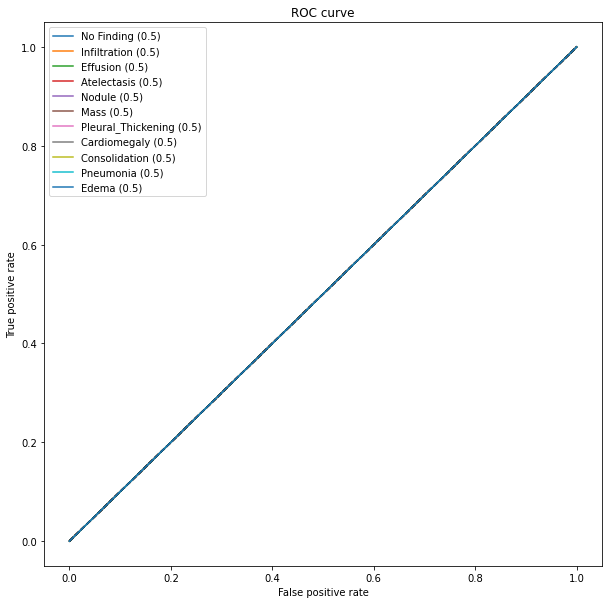

In [27]:
roc_auc_vals = get_roc_curve(y_test,y_preds_final)

## **DenseNet Training**

In [28]:
df = pd.read_csv("csv files/no_sampling_index_csv/added_paths_AP.csv")
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],full_path
0,00000032_000.png,Cardiomegaly,0,32,55,F,AP,2500,2048,0.168,0.168,images/images1/00000032_000.png
1,00000032_001.png,Cardiomegaly,1,32,55,F,AP,2500,2048,0.168,0.168,images/images1/00000032_001.png
2,00000032_001.png,Edema,1,32,55,F,AP,2500,2048,0.168,0.168,images/images1/00000032_001.png
3,00000032_001.png,Effusion,1,32,55,F,AP,2500,2048,0.168,0.168,images/images1/00000032_001.png
4,00000032_002.png,No Finding,2,32,55,F,AP,2500,2048,0.168,0.168,images/images1/00000032_002.png


In [29]:
df_final = df[df['Finding Labels']!= 'No Finding']

In [30]:
df_final.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],full_path
0,00000032_000.png,Cardiomegaly,0,32,55,F,AP,2500,2048,0.168,0.168,images/images1/00000032_000.png
1,00000032_001.png,Cardiomegaly,1,32,55,F,AP,2500,2048,0.168,0.168,images/images1/00000032_001.png
2,00000032_001.png,Edema,1,32,55,F,AP,2500,2048,0.168,0.168,images/images1/00000032_001.png
3,00000032_001.png,Effusion,1,32,55,F,AP,2500,2048,0.168,0.168,images/images1/00000032_001.png
6,00000032_004.png,Edema,4,32,55,F,AP,2500,2048,0.168,0.168,images/images1/00000032_004.png


In [31]:
df.shape

(5637, 12)

In [32]:
df_final.shape

(3397, 12)

In [33]:
train, validate, test = np.split(df_final.sample(frac=1), [int(.6*len(df_final)), int(.8*len(df_final))])
print(train)
train.to_csv("csv files/no_sampling_index_csv/train_df_DenseNet.csv", sep=',',index=False)
validate.to_csv("csv files/no_sampling_index_csv/valid_df_DenseNet.csv",sep=',',index=False)
test.to_csv("csv files/no_sampling_index_csv/test_df_DenseNet.csv",sep=',',index=False)
print(validate)
print(test)

           Image Index Finding Labels  ...     y]                         full_path
1800  00008051_022.png    Atelectasis  ...  0.168   images/images4/00008051_022.png
1274  00005683_000.png         Nodule  ...  0.171   images/images3/00005683_000.png
4753  00027357_005.png   Infiltration  ...  0.139  images/images11/00027357_005.png
5418  00030106_004.png       Effusion  ...  0.139  images/images12/00030106_004.png
3991  00020227_000.png       Effusion  ...  0.139   images/images9/00020227_000.png
...                ...            ...  ...    ...                               ...
4029  00020537_003.png         Nodule  ...  0.139   images/images9/00020537_003.png
5089  00029245_001.png   Infiltration  ...  0.139  images/images12/00029245_001.png
2250  00009863_054.png   Infiltration  ...  0.168   images/images5/00009863_054.png
620   00002548_001.png   Infiltration  ...  0.171   images/images2/00002548_001.png
1980  00008774_005.png  Consolidation  ...  0.171   images/images4/00008774_

In [34]:
!ls "csv files/no_sampling_index_csv/"

added_paths_AP.csv  df_AP.csv  test_df_DenseNet.csv   valid_df_DenseNet.csv
added_paths_PA.csv  df_PA.csv  train_df_DenseNet.csv


In [35]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

In [36]:
MAPPER = dict(zip(labels,range(0,14)))
MAPPER

{'Atelectasis': 7,
 'Cardiomegaly': 0,
 'Consolidation': 13,
 'Edema': 12,
 'Effusion': 2,
 'Emphysema': 1,
 'Fibrosis': 11,
 'Hernia': 3,
 'Infiltration': 4,
 'Mass': 5,
 'Nodule': 6,
 'Pleural_Thickening': 9,
 'Pneumonia': 10,
 'Pneumothorax': 8}

In [37]:
opp_MAPPER = dict(zip(range(0,14),labels))
opp_MAPPER

{0: 'Cardiomegaly',
 1: 'Emphysema',
 2: 'Effusion',
 3: 'Hernia',
 4: 'Infiltration',
 5: 'Mass',
 6: 'Nodule',
 7: 'Atelectasis',
 8: 'Pneumothorax',
 9: 'Pleural_Thickening',
 10: 'Pneumonia',
 11: 'Fibrosis',
 12: 'Edema',
 13: 'Consolidation'}

In [38]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [39]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=image_dir, 
        x_col=x_col, 
        y_col=y_cols, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [40]:
train_generator = get_train_generator(train, None, "full_path", "Finding Labels",target_w=128,target_h=128)
valid_generator, test_generator= get_test_and_valid_generator(validate,test,train,None,"full_path","Finding Labels",target_h=128,target_w=128)

getting train generator...


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="full_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2037 validated image filenames.
getting train and valid generators...
Found 2038 validated image filenames.
Found 679 validated image filenames.
Found 680 validated image filenames.


In [41]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
            #complete this line
        return loss
    
        ### END CODE HERE ###
    return weighted_loss

In [42]:
train_generator.labels

array(['Atelectasis', 'Infiltration', 'Effusion', ..., 'Infiltration',
       'Infiltration', 'Consolidation'], dtype=object)

In [43]:
all_labels = train['Finding Labels'].map(lambda x: MAPPER[x])
all_labels

1800     7
1274     6
4753     4
5418     2
3991     2
        ..
4029     6
5089     4
2250     4
620      4
1980    13
Name: Finding Labels, Length: 2038, dtype: int64

In [44]:
test_labels = test['Finding Labels'].map(lambda x: MAPPER[x])
test_labels

2121     7
5016     4
3696     4
3908     0
3502    13
        ..
3854     2
4292     7
2907     5
4796     7
4895     4
Name: Finding Labels, Length: 680, dtype: int64

In [45]:
def compute_class_freqs(val_labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # total number of patients (rows)
    N = val_labels.shape[0]
    
    positive_frequencies = np.sum(val_labels, axis = 0) / N
    negative_frequencies = 1- positive_frequencies

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

freq_pos, freq_neg = compute_class_freqs(all_labels)
freq_pos

5.806673209028459

In [46]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

In [50]:
# create the base pre-trained model
base_model = keras.applications.DenseNet121(weights='/content/drive/Shareddrives/ECS 289G Deep Learning Project/Project/Datasets/bin_files/DenseNet/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = keras.layers.GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = keras.layers.Dense(len(opp_MAPPER.keys()), activation="sigmoid")(x)

model = keras.models.Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

In [52]:
model.load_weights("/content/drive/Shareddrives/ECS 289G Deep Learning Project/Project/Datasets/bin_files/DenseNet/pretrained_model.h5")

In [53]:
predicted_vals = model.predict(test_generator,test_generator.labels)

In [54]:
predicted_vals[:10]

array([[0.1723311 , 0.1798994 , 0.3298748 , 0.4757997 , 0.34224188,
        0.314919  , 0.43643776, 0.3676927 , 0.3126101 , 0.28584647,
        0.5413778 , 0.62042147, 0.19573069, 0.55408716],
       [0.08714092, 0.9723568 , 0.18246669, 0.48792684, 0.47001114,
        0.3443602 , 0.3091666 , 0.5493446 , 0.9405619 , 0.15116337,
        0.31697252, 0.0504548 , 0.10476142, 0.44477212],
       [0.1408726 , 0.5831387 , 0.07398465, 0.601614  , 0.30944526,
        0.36034483, 0.22469768, 0.53521264, 0.35390705, 0.42724746,
        0.30077198, 0.5127026 , 0.10612637, 0.39639324],
       [0.13053939, 0.43803436, 0.6413847 , 0.54289377, 0.5289127 ,
        0.36491892, 0.24776429, 0.7895583 , 0.61694694, 0.25172353,
        0.40890643, 0.11348844, 0.0802564 , 0.65502995],
       [0.06302279, 0.3430485 , 0.19377443, 0.52418   , 0.35952595,
        0.46005136, 0.26848283, 0.4432296 , 0.14819813, 0.25541118,
        0.36116803, 0.1884478 , 0.11186358, 0.49024746],
       [0.2536615 , 0.9777719 , 0.6

In [55]:
true_label = get_one_hot_stuff(test_generator.labels,MAPPER)

(680, 14)


In [56]:
true_label[:10]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

Error in generating ROC curve for Hernia. Dataset lacks enough examples.


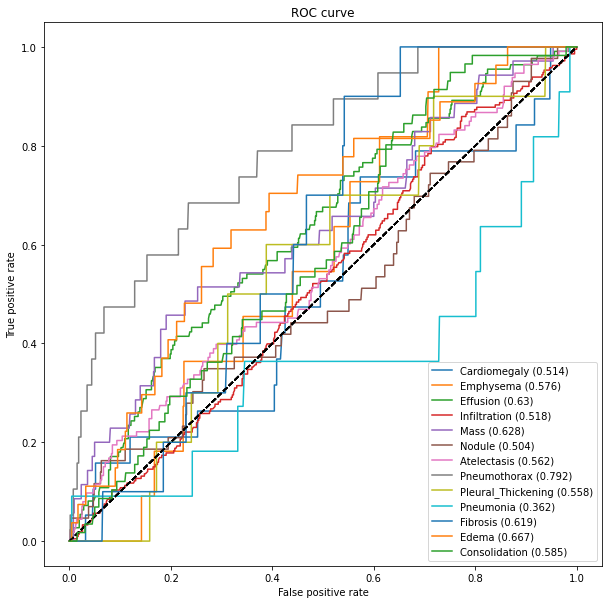

In [57]:
auc_rocs = get_roc_curve_again(labels,predicted_vals,true_label)